In [ ]:
import sys
IN_COLAB = 'google.colab' in sys.modules

! git clone https://github.com/swarnabha13/ai-economist.git
%cd ai-economist
! pip install -e .

In [3]:
from ai_economist import foundation
from ai_economist.foundation.base.base_env import BaseEnvironment, scenario_registry
test_env_cls = scenario_registry.get("layout_from_file/simple_wood_and_stone")

In [4]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from IPython import display
if IN_COLAB:
    from tutorials.utils import plotting  # plotting utilities for visualizing env state
else:
    from utils import plotting

In [7]:
from ai_economist.foundation.entities.resources import Resource, resource_registry

@resource_registry.add
class Widget(Resource):
    name = "Widget"
    color = [1, 1, 1]
    collectible = False # <--- Goes in agent inventory, but not in the world

In [8]:
ls

ai_economist/
ai_economist.egg-info/
CHANGELOG.md
CODE_OF_CONDUCT.md
CONTRIBUTING.md
format_and_lint.sh*
LICENSE.txt
README.md
requirements.txt
SECURITY.md
setup.py
Simulation_Card_Foundation_Economic_Simulation_Framework.pdf
tests/
tutorials/


In [9]:
import matplotlib.pyplot as plt
from ai_economist.foundation.base.base_component import BaseComponent, component_registry
import random

@component_registry.add
class BuyWidgetFromVirtualStore(BaseComponent):
    name = "BuyWidgetFromVirtualStore"
    required_entities = ["Coin", "Widget"]  # <--- We can now look up "Widget" in the resource registry
    agent_subclasses = ["BasicMobileAgent"]

    def __init__(
        self,
        *base_component_args,
        widget_refresh_rate=0.1,
        **base_component_kwargs
    ):
        super().__init__(*base_component_args, **base_component_kwargs)
        self.widget_refresh_rate = widget_refresh_rate
        self.available_widget_units = 0
        self.widget_price = 5

    def get_additional_state_fields(self, agent_cls_name):
        return {}

    def additional_reset_steps(self):
        self.available_wood_units = 0

    def get_n_actions(self, agent_cls_name):
        if agent_cls_name == "BasicMobileAgent":
            return 1
        return None

    def generate_masks(self, completions=0):
        masks = {}
        for agent in self.world.agents:
            masks[agent.idx] = np.array([
                agent.state["inventory"]["Coin"] >= self.widget_price and self.available_widget_units > 0
            ])

        return masks

    def component_step(self):
        if random.random() < self.widget_refresh_rate: 
            self.available_widget_units += 1

        for agent in self.world.get_random_order_agents():

            action = agent.get_component_action(self.name)

            if action == 0: # NO-OP. Agent is not interacting with this component.
                continue

            if action == 1: # Agent wants to buy. Execute a purchase if possible.
                if self.available_widget_units > 0 and agent.state["inventory"]["Coin"] >= self.widget_price: 
                    agent.state["inventory"]["Coin"] -= self.widget_price
                    agent.state["inventory"]["Widget"] += 1
                    self.available_widget_units -= 1

            else: # We only declared 1 action for this agent type, so action > 1 is an error.
                raise ValueError

    def generate_observations(self):
        obs_dict = dict()
        for agent in self.world.agents:
            obs_dict[agent.idx] = {
                "widget_refresh_rate": self.widget_refresh_rate,
                "available_widget_units": self.available_widget_units,
                "widget_price": self.widget_price
            }

        return obs_dict

In [10]:
# Define the configuration of the environment that will be built

env_config = {
    # ===== STANDARD ARGUMENTS ======
    'n_agents': 4,          # Number of non-planner agents
    'world_size': [25, 25], # [Height, Width] of the env world
    'episode_length': 1000, # Number of timesteps per episode
    
    # In multi-action-mode, the policy selects an action for each action subspace (defined in component code)
    # Otherwise, the policy selects only 1 action
    'multi_action_mode_agents': False,
    'multi_action_mode_planner': True,
    
    # When flattening observations, concatenate scalar & vector observations before output
    # Otherwise, return observations with minimal processing
    'flatten_observations': False,
    # When Flattening masks, concatenate each action subspace mask into a single array
    # Note: flatten_masks = True is recommended for masking action logits
    'flatten_masks': True,
    
    
    # ===== COMPONENTS =====
    # Which components to use (specified as list of {"component_name": {component_kwargs}} dictionaries)
    #   "component_name" refers to the component class's name in the Component Registry
    #   {component_kwargs} is a dictionary of kwargs passed to the component class
    # The order in which components reset, step, and generate obs follows their listed order below
    'components': [
        # (1) Building houses
        ('Build', dict(skill_dist="beta", payment_max_skill_multiplier=3)),
        # (2) Trading collectible resources
        ('ContinuousDoubleAuction', dict(max_num_orders=5)),
        # (3) Movement and resource collection
        ('Gather', dict()),
    ],
    
    # ===== SCENARIO =====
    # Which scenario class to use (specified by the class's name in the Scenario Registry)
    'scenario_name': 'uniform/simple_wood_and_stone',
    #'env_layout_file': 'quadrant_25x25_20each_30clump.txt',
    
    # (optional) kwargs of the chosen scenario class
    'starting_agent_coin': 10,
    'starting_stone_coverage': 0.10,
    'starting_wood_coverage':  0.10,
}

In [11]:
from copy import deepcopy
new_env_config = deepcopy(env_config)

# Compared to env_config, new_env_config simply adds our new Component
new_env_config['components'] = [
    # (1) Building houses
    ('Build', dict(skill_dist="beta", payment_max_skill_multiplier=3)),
    # (2) Trading collectible resources
    ('ContinuousDoubleAuction', dict(max_num_orders=5)),
    # (3) Movement and resource collection
    ('Gather', dict(skill_dist="pareto")),
    # (4) Let each mobile agent buy widgets from a virtual store.
    {'BuyWidgetFromVirtualStore': {'widget_refresh_rate': 0.1}},  # <--- This.
]

In [12]:
new_env = foundation.make_env_instance(**new_env_config)
obs = new_env.reset()

In [13]:
new_agent0 = new_env.get_agent(agent_idx=0)
new_agent0.state

{'bonus_gather_prob': 0.05351415077493127,
 'build_payment': 23.4771136758218,
 'build_skill': 0.67385568379109,
 'endogenous': {'Labor': 0},
 'escrow': {'Coin': 0, 'Stone': 0, 'Widget': 0, 'Wood': 0},
 'inventory': {'Coin': 10.0, 'Stone': 0, 'Widget': 0, 'Wood': 0},
 'loc': [12, 24]}

In [14]:
new_agent0.action_dim

{'Build': 1,
 'BuyWidgetFromVirtualStore': 1,
 'ContinuousDoubleAuction.Buy_Stone': 11,
 'ContinuousDoubleAuction.Buy_Wood': 11,
 'ContinuousDoubleAuction.Sell_Stone': 11,
 'ContinuousDoubleAuction.Sell_Wood': 11,
 'Gather': 4}

In [15]:
new_env.world.maps.keys()

dict_keys(['Stone', 'Wood', 'House', 'StoneSourceBlock', 'WoodSourceBlock'])

In [16]:
obs.keys()

dict_keys(['0', '1', '2', '3', 'p'])

In [17]:
# Note: The code for sampling actions (this cell), and playing an episode (below) are general.  
# That is, it doesn't depend on the Scenario and Component classes used in the environment!

def sample_random_action(agent, mask):
    """Sample random UNMASKED action(s) for agent."""
    # Return a list of actions: 1 for each action subspace
    if agent.multi_action_mode:
        split_masks = np.split(mask, agent.action_spaces.cumsum()[:-1])
        return [np.random.choice(np.arange(len(m_)), p=m_/m_.sum()) for m_ in split_masks]

    # Return a single action
    else:
        return np.random.choice(np.arange(agent.action_spaces), p=mask/mask.sum())

def sample_random_actions(env, obs):
    """Samples random UNMASKED actions for each agent in obs."""
        
    actions = {
        a_idx: sample_random_action(env.get_agent(a_idx), a_obs['action_mask'])
        for a_idx, a_obs in obs.items()
    }

    return actions

In [18]:
def do_plot(env, ax, fig):
    """Plots world state during episode sampling."""
    plotting.plot_env_state(env, ax)
    ax.set_aspect('equal')
    display.display(fig)
    display.clear_output(wait=True)

def play_random_episode(env, plot_every=100, do_dense_logging=False):
    """Plays an episode with randomly sampled actions.
    
    Demonstrates gym-style API:
        obs                  <-- env.reset(...)         # Reset
        obs, rew, done, info <-- env.step(actions, ...) # Interaction loop
    
    """
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))

    # Reset
    obs = env.reset(force_dense_logging=do_dense_logging)

    # Interaction loop (w/ plotting)
    for t in range(env.episode_length):
        actions = sample_random_actions(env, obs)
        obs, rew, done, info = env.step(actions)

        if ((t+1) % plot_every) == 0:
            do_plot(env, ax, fig)

    if ((t+1) % plot_every) != 0:
        do_plot(env, ax, fig)        

In [19]:
new_env.world.maps.values

<bound method Maps.values of <ai_economist.foundation.base.world.Maps object at 0x7ff548bcd0d0>>

Plotting starts

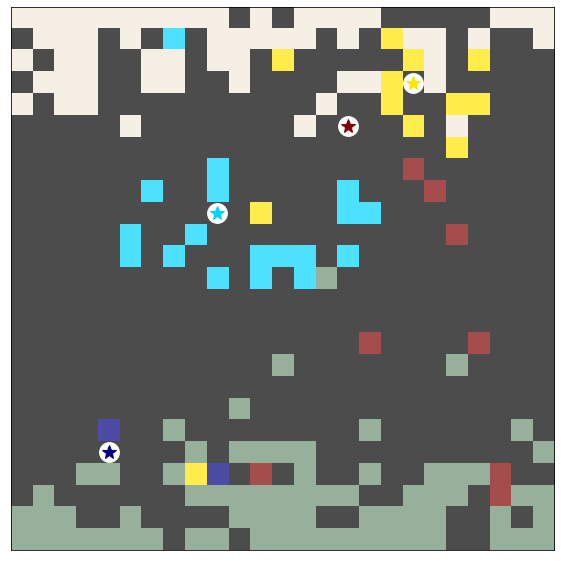

In [20]:
play_random_episode(new_env, plot_every=100)

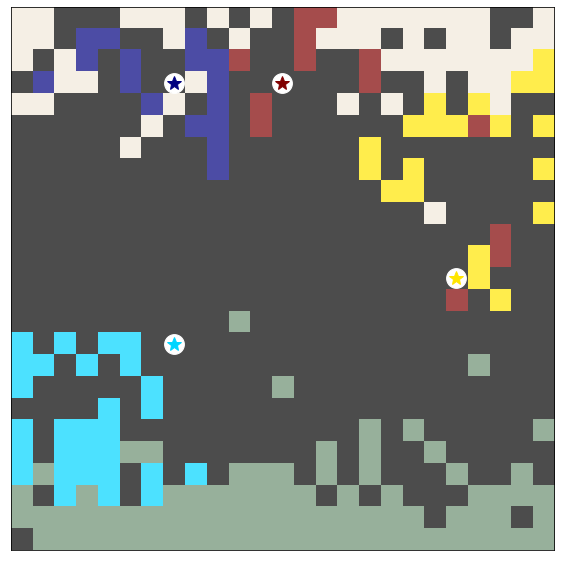

In [21]:
# Play another episode. This time, tell the environment to do dense logging
play_random_episode(new_env, plot_every=100, do_dense_logging=True)

# Grab the dense log from the env
dense_log = new_env.previous_episode_dense_log

In [22]:
agent0 = new_env.get_agent(agent_idx=0)
agent0.state

{'bonus_gather_prob': 0.1776842074701196,
 'build_payment': 19.254152575935738,
 'build_skill': 0.46270762879678684,
 'endogenous': {'Labor': 739.25},
 'escrow': {'Coin': 9.0, 'Stone': 3.0, 'Widget': 0, 'Wood': 1.0},
 'inventory': {'Coin': 124.06644121497177,
  'Stone': 47.0,
  'Widget': 31,
  'Wood': 0.0},
 'loc': [3, 7]}

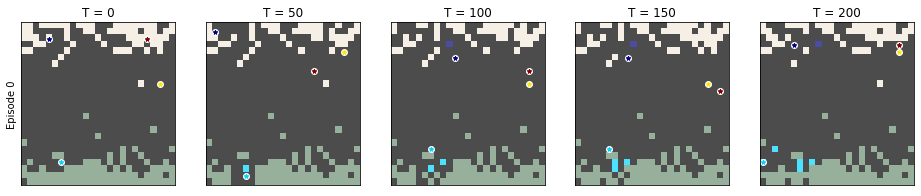

In [23]:
# Show the evolution of the world state from t=0 to t=200
fig = plotting.vis_world_range(dense_log, t0=0, tN=200, N=5)

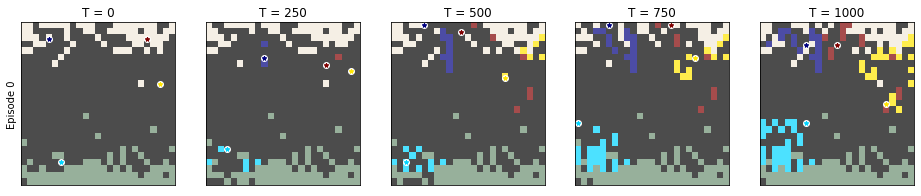

In [24]:
# Show the evolution of the world state over the full episode
fig = plotting.vis_world_range(dense_log, N=5)

_______________:_ Agent  0 _____|_ Agent  1 _____|_ Agent  2 _____|_ Agent  3 ____
Cost (Wood)    :   5.84 (n= 68) |   6.10 (n= 52) |   5.40 (n= 80) |   5.41 (n= 75)
Cost (Stone)   :   3.72 (n= 71) |   4.35 (n= 88) |   4.41 (n= 68) |   4.28 (n= 68)

Income (Wood)  :   5.76 (n= 51) |   5.42 (n=111) |   5.95 (n= 56) |   5.67 (n= 57)
Income (Stone) :   4.38 (n= 77) |   3.75 (n= 55) |   4.26 (n= 78) |   4.27 (n= 85)
Income (Build) :  19.25 (n= 16) |  18.80 (n= 29) |  23.22 (n= 20) |  15.17 (n= 13)


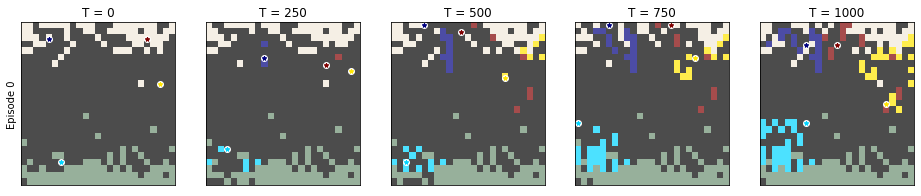

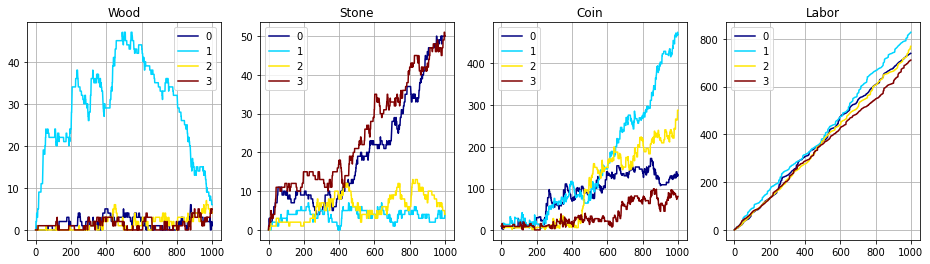

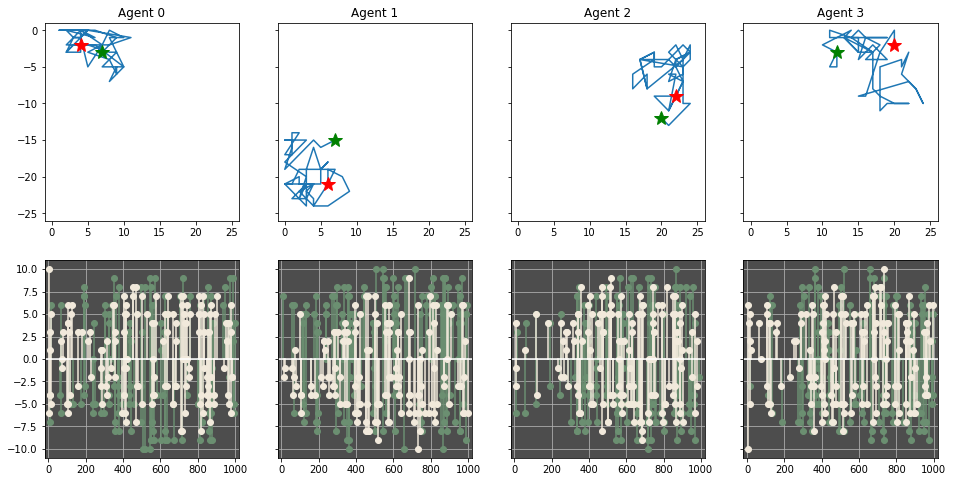

In [25]:
# Use the "breakdown" tool to visualize the world state, agent-wise quantities, movement, and trading events
plotting.breakdown(dense_log);

In [26]:
new_env.world.agents[0].state

{'bonus_gather_prob': 0.1776842074701196,
 'build_payment': 19.254152575935738,
 'build_skill': 0.46270762879678684,
 'endogenous': {'Labor': 739.25},
 'escrow': {'Coin': 9.0, 'Stone': 3.0, 'Widget': 0, 'Wood': 1.0},
 'inventory': {'Coin': 124.06644121497177,
  'Stone': 47.0,
  'Widget': 31,
  'Wood': 0.0},
 'loc': [3, 7]}

In [27]:
new_env.world.agents[1].state

{'bonus_gather_prob': 1.0,
 'build_payment': 18.79634193832697,
 'build_skill': 0.4398170969163487,
 'endogenous': {'Labor': 827.5},
 'escrow': {'Coin': 4.0, 'Stone': 2.0, 'Widget': 0, 'Wood': 2.0},
 'inventory': {'Coin': 464.0939162114822,
  'Stone': 2.0,
  'Widget': 39,
  'Wood': 4.0},
 'loc': [15, 7]}

In [28]:
new_env.world.agents[2].state

{'bonus_gather_prob': 0.20079179815955372,
 'build_payment': 23.22452292036835,
 'build_skill': 0.6612261460184174,
 'endogenous': {'Labor': 768.75},
 'escrow': {'Coin': 8.0, 'Stone': 4.0, 'Widget': 0, 'Wood': 3.0},
 'inventory': {'Coin': 279.49045840736693,
  'Stone': 0.0,
  'Widget': 24,
  'Wood': 1.0},
 'loc': [12, 20]}

In [29]:
new_env.world.agents[3].state

{'bonus_gather_prob': 0.28751321134568897,
 'build_payment': 15.16704032962479,
 'build_skill': 0.2583520164812395,
 'endogenous': {'Labor': 711.0},
 'escrow': {'Coin': 9.0, 'Stone': 4.0, 'Widget': 0, 'Wood': 2.0},
 'inventory': {'Coin': 72.17152428512227,
  'Stone': 46.0,
  'Widget': 23,
  'Wood': 3.0},
 'loc': [3, 12]}

In [30]:
for agent in new_env.world.agents:
    print('Agent {} coin-per-house: {}'.format(agent.idx, agent.state['build_payment']))

Agent 0 coin-per-house: 19.254152575935738
Agent 1 coin-per-house: 18.79634193832697
Agent 2 coin-per-house: 23.22452292036835
Agent 3 coin-per-house: 15.16704032962479


Plotting ends

In [31]:
new_env.world.maps.keys()

dict_keys(['Stone', 'Wood', 'House', 'StoneSourceBlock', 'WoodSourceBlock'])

In [32]:
from ai_economist.foundation.entities.landmarks import Landmark, landmark_registry

@resource_registry.add
class Widget(Resource):
    name = "Widget"
    color = np.array([255, 255, 255]) / 255.0
    collectible = True # <--- Goes in agent inventory, AND in the world
    
# Since we're doing this in a notebook, we need to manually add a Source Block Landmark for Widgets.
#     If we defined the Widget class in /foundation/entities/resources.py,
#     this class construction would happen automatically.
@landmark_registry.add
class SourceBlock(Landmark):
    """Special Landmark for generating collectible resources. Not ownable. Not solid."""

    name = "{}SourceBlock".format(Widget.name)
    color = np.array(Widget.color)
    ownable = False
    solid = False

In [33]:
new_env_with_collectible_widgets = foundation.make_env_instance(**new_env_config)

new_env_with_collectible_widgets.world.maps.keys()

dict_keys(['Stone', 'Widget', 'Wood', 'House', 'StoneSourceBlock', 'WidgetSourceBlock', 'WoodSourceBlock'])

In [34]:
new_env.world.maps.keys()

dict_keys(['Stone', 'Wood', 'House', 'StoneSourceBlock', 'WoodSourceBlock'])

In [35]:
# Copyright (c) 2020, salesforce.com, inc.
# All rights reserved.
# SPDX-License-Identifier: BSD-3-Clause
# For full license text, see the LICENSE file in the repo root
# or https://opensource.org/licenses/BSD-3-Clause

import matplotlib.pyplot as plt
import numpy as np

from ai_economist.foundation import landmarks, resources


def plot_map(maps, locs, ax=None, cmap_order=None):
    world_size = np.array(maps.get("Wood")).shape
    max_health = {"Wood": 1, "Stone": 1, "House": 1, "Widget": 1}
    n_agents = len(locs)

    if ax is None:
        _, ax = plt.subplots(1, 1, figsize=(10, 10))
    else:
        ax.cla()
    tmp = np.zeros((3, world_size[0], world_size[1]))
    cmap = plt.get_cmap("jet", n_agents)

    if cmap_order is None:
        cmap_order = list(range(n_agents))
    else:
        cmap_order = list(cmap_order)
        assert len(cmap_order) == n_agents

    scenario_entities = [k for k in maps.keys() if "source" not in k.lower()]
    for entity in scenario_entities:
        if entity == "House":
            continue
        elif resources.has(entity):
            if resources.get(entity).collectible:
                map_ = (
                    resources.get(entity).color[:, None, None]
                    * np.array(maps.get(entity))[None]
                )
                map_ /= max_health[entity]
                tmp += map_
        elif landmarks.has(entity):
            map_ = (
                landmarks.get(entity).color[:, None, None]
                * np.array(maps.get(entity))[None]
            )
            tmp += map_
        else:
            continue

    if isinstance(maps, dict):
        house_idx = np.array(maps.get("House")["owner"])
        house_health = np.array(maps.get("House")["health"])
    else:
        house_idx = maps.get("House", owner=True)
        house_health = maps.get("House")
    for i in range(n_agents):
        houses = house_health * (house_idx == cmap_order[i])
        agent = np.zeros_like(houses)
        agent += houses
        col = np.array(cmap(i)[:3])
        map_ = col[:, None, None] * agent[None]
        tmp += map_

    tmp *= 0.7
    tmp += 0.3

    tmp = np.transpose(tmp, [1, 2, 0])
    tmp = np.minimum(tmp, 1.0)

    ax.imshow(tmp, vmax=1.0, aspect="auto")

    bbox = ax.get_window_extent()

    for i in range(n_agents):
        r, c = locs[cmap_order[i]]
        col = np.array(cmap(i)[:3])
        ax.plot(c, r, "o", markersize=bbox.height * 20 / 550, color="w")
        ax.plot(c, r, "*", markersize=bbox.height * 15 / 550, color=col)

    ax.set_xticks([])
    ax.set_yticks([])


def plot_env_state(env, ax=None, remap_key=None):
    maps = env.world.maps
    locs = [agent.loc for agent in env.world.agents]

    if remap_key is None:
        cmap_order = None
    else:
        assert isinstance(remap_key, str)
        cmap_order = np.argsort(
            [agent.state[remap_key] for agent in env.world.agents]
        ).tolist()

    plot_map(maps, locs, ax, cmap_order)


def plot_log_state(dense_log, t, ax=None, remap_key=None):
    maps = dense_log["world"][t]
    states = dense_log["states"][t]

    n_agents = len(states) - 1
    locs = []
    for i in range(n_agents):
        r, c = states[str(i)]["loc"]
        locs.append([r, c])

    if remap_key is None:
        cmap_order = None
    else:
        assert isinstance(remap_key, str)
        key_val = np.array(
            [dense_log["states"][0][str(i)][remap_key] for i in range(n_agents)]
        )
        cmap_order = np.argsort(key_val).tolist()

    plot_map(maps, locs, ax, cmap_order)


def _format_logs_and_eps(dense_logs, eps):
    if isinstance(dense_logs, dict):
        return [dense_logs], [0]
    else:
        assert isinstance(dense_logs, (list, tuple))

    if isinstance(eps, (list, tuple)):
        return dense_logs, list(eps)
    elif isinstance(eps, (int, float)):
        return dense_logs, [int(eps)]
    elif eps is None:
        return dense_logs, list(range(np.minimum(len(dense_logs), 16)))
    else:
        raise NotImplementedError


def vis_world_array(dense_logs, ts, eps=None, axes=None, remap_key=None):
    dense_logs, eps = _format_logs_and_eps(dense_logs, eps)
    if isinstance(ts, (int, float)):
        ts = [ts]

    if axes is None:
        fig, axes = plt.subplots(
            len(eps),
            len(ts),
            figsize=(np.minimum(3.2 * len(ts), 16), 3 * len(eps)),
            squeeze=False,
        )

    else:
        fig = None

        if len(ts) == 1 and len(eps) == 1:
            axes = np.array([[axes]]).reshape(1, 1)
        else:
            try:
                axes = np.array(axes).reshape(len(eps), len(ts))
            except ValueError:
                print("Could not reshape provided axes array into the necessary shape!")
                raise

    for ti, t in enumerate(ts):
        for ei, ep in enumerate(eps):
            plot_log_state(dense_logs[ep], t, ax=axes[ei, ti], remap_key=remap_key)

    for ax, t in zip(axes[0], ts):
        ax.set_title("T = {}".format(t))
    for ax, ep in zip(axes[:, 0], eps):
        ax.set_ylabel("Episode {}".format(ep))

    return fig


def vis_world_range(
    dense_logs, t0=0, tN=None, N=5, eps=None, axes=None, remap_key=None
):
    dense_logs, eps = _format_logs_and_eps(dense_logs, eps)

    viable_ts = np.array([i for i, w in enumerate(dense_logs[0]["world"]) if w])
    if tN is None:
        tN = viable_ts[-1]
    assert 0 <= t0 < tN
    target_ts = np.linspace(t0, tN, N).astype(np.int)

    ts = set()
    for tt in target_ts:
        closest = np.argmin(np.abs(tt - viable_ts))
        ts.add(viable_ts[closest])
    ts = sorted(list(ts))
    if axes is not None:
        axes = axes[: len(ts)]
    return vis_world_array(dense_logs, ts, axes=axes, eps=eps, remap_key=remap_key)


def vis_builds(dense_logs, eps=None, ax=None):
    dense_logs, eps = _format_logs_and_eps(dense_logs, eps)

    if ax is None:
        _, ax = plt.subplots(1, 1, figsize=(16, 3))
    cmap = plt.get_cmap("jet", len(eps))
    for i, ep in enumerate(eps):
        ax.plot(
            np.cumsum([len(b["builds"]) for b in dense_logs[ep]["Build"]]),
            color=cmap(i),
            label="Ep {}".format(ep),
        )
    ax.legend()
    ax.grid(b=True)
    ax.set_ylim(bottom=0)


def trade_str(c_trades, resource, agent, income=True):
    if income:
        p = [x["income"] for x in c_trades[resource] if x["seller"] == agent]
    else:
        p = [x["cost"] for x in c_trades[resource] if x["buyer"] == agent]
    if len(p) > 0:
        return "{:6.2f} (n={:3d})".format(np.mean(p), len(p))
    else:
        tmp = "~" * 8
        tmp = (" ") * 3 + tmp + (" ") * 3
        return tmp


def full_trade_str(c_trades, resource, a_indices, income=True):
    s_head = "{} ({})".format("Income" if income else "Cost", resource)
    ac_strings = [trade_str(c_trades, resource, buyer, income) for buyer in a_indices]
    s_tail = " | ".join(ac_strings)
    return "{:<15}: {}".format(s_head, s_tail)


def build_str(all_builds, agent):
    p = [x["income"] for x in all_builds if x["builder"] == agent]
    if len(p) > 0:
        return "{:6.2f} (n={:3d})".format(np.mean(p), len(p))
    else:
        tmp = "~" * 8
        tmp = (" ") * 3 + tmp + (" ") * 3
        return tmp


def full_build_str(all_builds, a_indices):
    s_head = "Income (Build)"
    ac_strings = [build_str(all_builds, builder) for builder in a_indices]
    s_tail = " | ".join(ac_strings)
    return "{:<15}: {}".format(s_head, s_tail)


def header_str(n_agents):
    s_head = ("_" * 15) + ":_"
    s_tail = "_|_".join([" Agent {:2d} ____".format(i) for i in range(n_agents)])
    return s_head + s_tail


def report(c_trades, all_builds, n_agents, a_indices=None):
    if a_indices is None:
        a_indices = list(range(n_agents))
    print(header_str(n_agents))
    resources = ["Wood", "Stone"]
    if c_trades is not None:
        for resource in resources:
            print(full_trade_str(c_trades, resource, a_indices, income=False))
        print("")
        for resource in resources:
            print(full_trade_str(c_trades, resource, a_indices, income=True))
    print(full_build_str(all_builds, a_indices))


def breakdown(log, remap_key=None):
    fig0 = vis_world_range(log, remap_key=remap_key)

    n = len(list(log["states"][0].keys())) - 1
    trading_active = "Trade" in log

    if remap_key is None:
        aidx = list(range(n))
    else:
        assert isinstance(remap_key, str)
        key_vals = np.array([log["states"][0][str(i)][remap_key] for i in range(n)])
        aidx = np.argsort(key_vals).tolist()

    all_builds = []
    for t, builds in enumerate(log["Build"]):
        if isinstance(builds, dict):
            builds_ = builds["builds"]
        else:
            builds_ = builds
        for build in builds_:
            this_build = {"t": t}
            this_build.update(build)
            all_builds.append(this_build)

    if trading_active:
        c_trades = {"Stone": [], "Wood": [], "Widget": []}
        for t, trades in enumerate(log["Trade"]):
            if isinstance(trades, dict):
                trades_ = trades["trades"]
            else:
                trades_ = trades
            for trade in trades_:
                this_trade = {
                    "t": t,
                    "t_ask": t - trade["ask_lifetime"],
                    "t_bid": t - trade["bid_lifetime"],
                }
                this_trade.update(trade)
                c_trades[trade["commodity"]].append(this_trade)

        incomes = {
            "Sell Stone": [
                sum([t["income"] for t in c_trades["Stone"] if t["seller"] == aidx[i]])
                for i in range(n)
            ],
            "Buy Stone": [
                sum([-t["price"] for t in c_trades["Stone"] if t["buyer"] == aidx[i]])
                for i in range(n)
            ],
            "Sell Wood": [
                sum([t["income"] for t in c_trades["Wood"] if t["seller"] == aidx[i]])
                for i in range(n)
            ],
            "Buy Wood": [
                sum([-t["price"] for t in c_trades["Wood"] if t["buyer"] == aidx[i]])
                for i in range(n)
            ],
            "Build": [
                sum([b["income"] for b in all_builds if b["builder"] == aidx[i]])
                for i in range(n)
            ],
        }

    else:
        c_trades = None
        incomes = {
            "Build": [
                sum([b["income"] for b in all_builds if b["builder"] == aidx[i]])
                for i in range(n)
            ],
        }

    incomes["Total"] = np.stack([v for v in incomes.values()]).sum(axis=0)

    endows = [
        int(
            log["states"][-1][str(aidx[i])]["inventory"]["Coin"]
            + log["states"][-1][str(aidx[i])]["escrow"]["Coin"]
        )
        for i in range(n)
    ]

    n_small = np.minimum(4, n)

    report(c_trades, all_builds, n, aidx)

    cmap = plt.get_cmap("jet", n)
    rs = ["Wood", "Stone", "Coin"]

    fig1, axes = plt.subplots(1, len(rs) + 1, figsize=(16, 4), sharey=False)
    for r, ax in zip(rs, axes):
        for i in range(n):
            ax.plot(
                [
                    x[str(aidx[i])]["inventory"][r] + x[str(aidx[i])]["escrow"][r]
                    for x in log["states"]
                ],
                label=i,
                color=cmap(i),
            )
        ax.set_title(r)
        ax.legend()
        ax.grid(b=True)

    ax = axes[-1]
    for i in range(n):
        ax.plot(
            [x[str(aidx[i])]["endogenous"]["Labor"] for x in log["states"]],
            label=i,
            color=cmap(i),
        )
    ax.set_title("Labor")
    ax.legend()
    ax.grid(b=True)

    tmp = np.array(log["world"][0]["Stone"])
    fig2, axes = plt.subplots(
        2 if trading_active else 1,
        n_small,
        figsize=(16, 8 if trading_active else 4),
        sharex="row",
        sharey="row",
        squeeze=False,
    )
    for i, ax in enumerate(axes[0]):
        rows = np.array([x[str(aidx[i])]["loc"][0] for x in log["states"]]) * -1
        cols = np.array([x[str(aidx[i])]["loc"][1] for x in log["states"]])
        ax.plot(cols[::20], rows[::20])
        ax.plot(cols[0], rows[0], "r*", markersize=15)
        ax.plot(cols[-1], rows[-1], "g*", markersize=15)
        ax.set_title("Agent {}".format(i))
        ax.set_xlim([-1, 1 + tmp.shape[1]])
        ax.set_ylim([-(1 + tmp.shape[0]), 1])

    if trading_active:
        for i, ax in enumerate(axes[1]):
            for r in ["Wood", "Stone"]:
                tmp = [
                    (s["t"], s["income"]) for s in c_trades[r] if s["seller"] == aidx[i]
                ]
                if tmp:
                    ts, prices = [np.array(x) for x in zip(*tmp)]
                    ax.plot(
                        np.stack([ts, ts]),
                        np.stack([np.zeros_like(prices), prices]),
                        color=resources.get(r).color,
                    )
                    ax.plot(
                        ts, prices, ".", color=resources.get(r).color, markersize=12
                    )

                tmp = [
                    (s["t"], -s["cost"]) for s in c_trades[r] if s["buyer"] == aidx[i]
                ]
                if tmp:
                    ts, prices = [np.array(x) for x in zip(*tmp)]
                    ax.plot(
                        np.stack([ts, ts]),
                        np.stack([np.zeros_like(prices), prices]),
                        color=resources.get(r).color,
                    )
                    ax.plot(
                        ts, prices, ".", color=resources.get(r).color, markersize=12
                    )
            ax.plot([-20, len(log["states"]) + 19], [0, 0], "w-")
            # ax.set_ylim([-10.2, 10.2]);
            ax.set_xlim([-20, len(log["states"]) + 19])
            ax.grid(b=True)
            ax.set_facecolor([0.3, 0.3, 0.3])

    return (fig0, fig1, fig2), incomes, endows, c_trades, all_builds


def plot_for_each_n(y_fun, n, ax=None):
    if ax is None:
        _, ax = plt.subplots(1, 1, figsize=(5, 5))
    cmap = plt.get_cmap("jet", n)
    for i in range(n):
        ax.plot(y_fun(i), color=cmap(i), label=i)
    ax.legend()
    ax.grid(b=True)


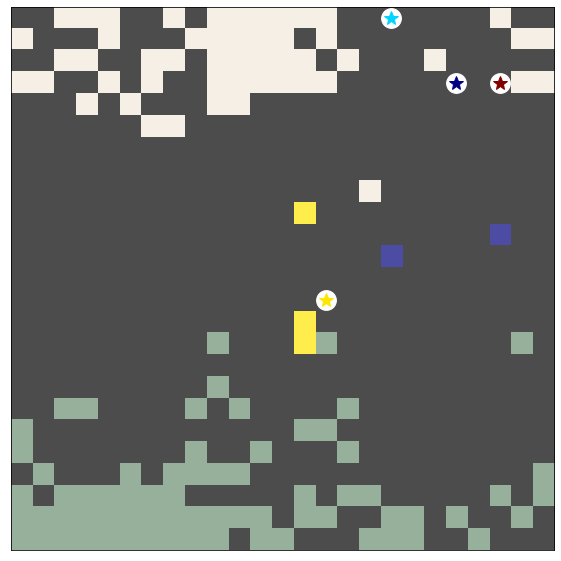

In [36]:
play_random_episode(new_env_with_collectible_widgets, plot_every=100)

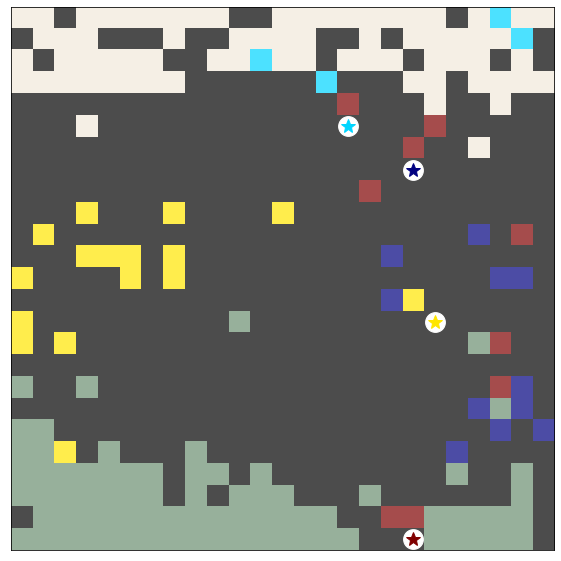

In [37]:
# Play another episode. This time, tell the environment to do dense logging
play_random_episode(new_env_with_collectible_widgets, plot_every=100, do_dense_logging=True)

# Grab the dense log from the env
dense_log = new_env_with_collectible_widgets.previous_episode_dense_log

_______________:_ Agent  0 _____|_ Agent  1 _____|_ Agent  2 _____|_ Agent  3 ____
Cost (Wood)    :   4.84 (n= 45) |   4.63 (n= 35) |   4.97 (n= 35) |   4.91 (n= 33)
Cost (Stone)   :   3.60 (n= 52) |   3.05 (n= 37) |   3.16 (n= 75) |   3.48 (n= 44)

Income (Wood)  :   5.06 (n= 36) |   4.63 (n= 30) |   4.96 (n= 50) |   4.59 (n= 32)
Income (Stone) :   3.41 (n= 46) |   3.48 (n= 42) |   3.21 (n= 57) |   3.24 (n= 63)
Income (Build) :  13.71 (n= 11) |  24.90 (n=  4) |  19.83 (n= 16) |  20.41 (n=  9)


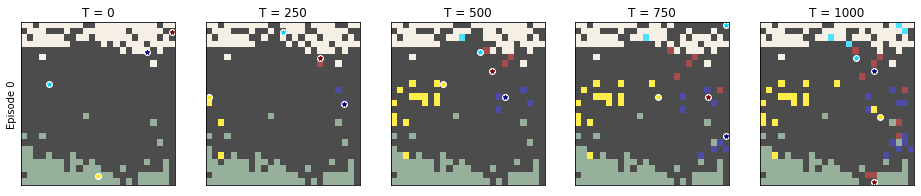

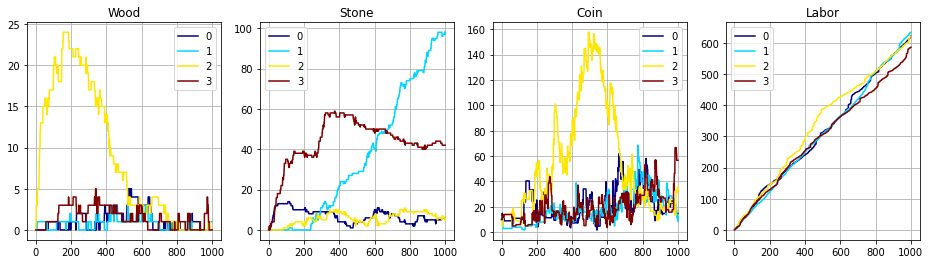

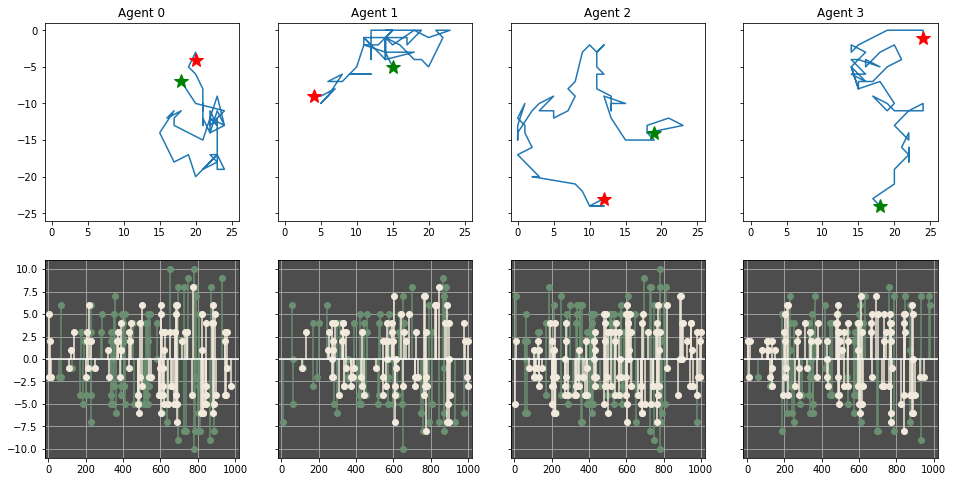

In [38]:
breakdown(dense_log);

In [39]:
new_env_with_collectible_widgets.world.agents[0].state

{'bonus_gather_prob': 0.015391234350958904,
 'build_payment': 13.710483249220724,
 'build_skill': 0.18552416246103623,
 'endogenous': {'Labor': 621.25},
 'escrow': {'Coin': 11.0, 'Stone': 5.0, 'Widget': 3.0, 'Wood': 0.0},
 'inventory': {'Coin': 3.8153157414279466,
  'Stone': 1.0,
  'Widget': 16.0,
  'Wood': 0.0},
 'loc': [7, 18]}

In [40]:
new_env_with_collectible_widgets.world.agents[1].state

{'bonus_gather_prob': 0.3758385641127545,
 'build_payment': 24.902497164691674,
 'build_skill': 0.7451248582345837,
 'endogenous': {'Labor': 634.0},
 'escrow': {'Coin': 7.0, 'Stone': 3.0, 'Widget': 4.0, 'Wood': 1.0},
 'inventory': {'Coin': 1.6099886587666958,
  'Stone': 95.0,
  'Widget': 24.0,
  'Wood': 0.0},
 'loc': [5, 15]}

In [41]:
new_env_with_collectible_widgets.world.agents[2].state

{'bonus_gather_prob': 0.2736665637744762,
 'build_payment': 19.826707850650507,
 'build_skill': 0.49133539253252545,
 'endogenous': {'Labor': 620.25},
 'escrow': {'Coin': 15.0, 'Stone': 1.0, 'Widget': 2.0, 'Wood': 0.0},
 'inventory': {'Coin': 21.227325610408116,
  'Stone': 4.0,
  'Widget': 59.0,
  'Wood': 0.0},
 'loc': [14, 19]}

In [42]:
new_env_with_collectible_widgets.world.agents[3].state

{'bonus_gather_prob': 1.0,
 'build_payment': 20.406155587937267,
 'build_skill': 0.5203077793968635,
 'endogenous': {'Labor': 585.75},
 'escrow': {'Coin': 13.0, 'Stone': 3.0, 'Widget': 3.0, 'Wood': 0.0},
 'inventory': {'Coin': 43.6554002914354,
  'Stone': 39.0,
  'Widget': 24.0,
  'Wood': 0.0},
 'loc': [24, 18]}

In [43]:
for agent in new_env_with_collectible_widgets.world.agents:
    print('Agent {} coin-per-house: {}'.format(agent.idx, agent.state['build_payment']))

Agent 0 coin-per-house: 13.710483249220724
Agent 1 coin-per-house: 24.902497164691674
Agent 2 coin-per-house: 19.826707850650507
Agent 3 coin-per-house: 20.406155587937267
